In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
# Function for converting series data to a supervised data of format, t-1, t, t+1
## Basically feeding in the (t-1)th data to predict the t data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [3]:
 
# load dataset
dataset = read_csv('/Users/manali/Downloads/train_data.csv')
dataset= dataset.drop(columns=["ID"])
values = dataset.values
print(dataset.head(5))
## Load Validation
validation = read_csv('/Users/manali/Downloads/test_data.csv')
validation= validation.drop(columns=["ID"])
values_validation = validation.values


   time_since_last_recording   latency      cost  reliability  \
0                   0.000000  0.433568  0.114583            1   
1                   0.911953  0.014534  0.354167            1   
2                   0.490876  0.030913  0.364583            1   
3                   0.410584  0.035595  0.354167            1   
4                   0.630474  0.067912  0.343750            1   

   time_since_last_ping  last_ping  
0              0.000000          0  
1              0.103199          1  
2              0.658927          1  
3              0.273478          1  
4              0.360681          1  


In [4]:
## Calling the function to do the preprocessing the data and removing unwanted columns


# frame as supervised learning
reframed = series_to_supervised(values, 1, 1)
reframed_validation = series_to_supervised(values_validation, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[6,10,11]], axis=1, inplace=True)
reframed_validation.drop(reframed_validation.columns[[6,10,11]], axis=1, inplace=True)
print(reframed.head(1))

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var2(t)  \
1        0.0   0.433568   0.114583        1.0        0.0        0.0  0.014534   

    var3(t)  var4(t)  
1  0.354167      1.0  


In [5]:
## Splitting the data into training and validation sets


train = reframed.values
test = reframed_validation.values
# split into input and outputs
train_X, train_y = train[:, :-3], train[:,-3:]
test_X, test_y = test[:, :-3], test[:,-3:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(149, 1, 6) (149, 3) (24, 1, 6) (24, 3)


Train on 149 samples, validate on 24 samples
Epoch 1/20
149/149 [==============================] - 1s 4ms/step - loss: 0.3997 - val_loss: 0.3546
Epoch 2/20
149/149 [==============================] - 0s 778us/step - loss: 0.2999 - val_loss: 0.2640
Epoch 3/20
149/149 [==============================] - 0s 830us/step - loss: 0.2129 - val_loss: 0.1830
Epoch 4/20
149/149 [==============================] - 0s 846us/step - loss: 0.1374 - val_loss: 0.1157
Epoch 5/20
149/149 [==============================] - 0s 828us/step - loss: 0.0779 - val_loss: 0.0677
Epoch 6/20
149/149 [==============================] - 0s 811us/step - loss: 0.0400 - val_loss: 0.0434
Epoch 7/20
149/149 [==============================] - 0s 808us/step - loss: 0.0261 - val_loss: 0.0397
Epoch 8/20
149/149 [==============================] - 0s 804us/step - loss: 0.0290 - val_loss: 0.0439
Epoch 9/20
149/149 [==============================] - 0s 815us/step - loss: 0.0339 - val_loss: 0.0452
Epoch 10/20
149/149 [==================

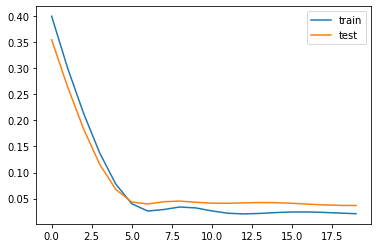

In [6]:
# design LSTM network  has 1000 hidden layers , used adam optimizer and mse loss function
model = Sequential()
model.add(LSTM(1000, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(3))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [13]:
### Doing the same process for testing dataset

test_dataset = read_csv('/Users/manali/Downloads/validate_data.csv')
test_dataset= test_dataset.drop(columns=["ID"])
test_values = test_dataset.values
reframed_test = series_to_supervised(test_values, 1, 1)
reframed_test.drop(reframed_test.columns[[6,10,11]], axis=1, inplace=True)
testset = reframed_test.values
testset_X, testset_y = testset[:, :-3], testset[:,-3:]
testdataReshaped = testset_X.reshape((testset_X.shape[0], 1, testset_X.shape[1]))
print(testset_X.shape, testset_X.shape)

(24, 6) (24, 6)


In [8]:
## Feeding the test dataset for predictions
import pandas as pd

yhat = model.predict(testdataReshaped)

print(yhat)
dataset = pd.DataFrame({'predicted_Latency': yhat[:, 0], 'predicted_Cost': yhat[:, 1],
                       'predicted_Reliability': yhat[:, 2]})
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] >0.5] = 1
dataset['predicted_Reliability'].loc[dataset['predicted_Reliability'] <0.5] = 0

[[0.18847723 0.3877949  1.0120301 ]
 [0.19295502 0.40066087 1.0290701 ]
 [0.13566183 0.36166486 0.94360185]
 [0.19832411 0.37070513 0.9590567 ]
 [0.12706389 0.37130743 0.9339345 ]
 [0.11256848 0.39253858 1.0005924 ]
 [0.1801075  0.40686506 1.0205599 ]
 [0.10192639 0.34560406 0.8542865 ]
 [0.13144122 0.34891692 0.9113975 ]
 [0.10979234 0.42243776 1.0552065 ]
 [0.29949817 0.32774425 1.0981088 ]
 [0.14204632 0.37170294 0.9580885 ]
 [0.24005178 0.45850164 1.169471  ]
 [0.07799827 0.3059907  0.7743904 ]
 [0.19610725 0.39525414 1.0366986 ]
 [0.3125508  0.19140728 0.8135635 ]
 [0.31297943 0.37216687 1.147762  ]
 [0.19617334 0.30164695 0.91499007]
 [0.23351775 0.3561718  1.048491  ]
 [0.16023496 0.36821562 0.94487894]
 [0.12723865 0.35380757 0.9077145 ]
 [0.15729195 0.3846737  0.96726745]
 [0.17166196 0.42283756 1.0788668 ]
 [0.17031728 0.33446157 0.92810273]]


In [9]:
frames = [test_dataset, dataset]
result = pd.concat(frames,axis =1)

In [10]:
import numpy as np
result.head(10)
result.to_csv('/Users/manali/JupyterProjects/predictions_LSTM.csv', sep=',', index=0)

In [11]:
print(testset_y)

[[4.57773760e-02 2.94117647e-01 1.00000000e+00]
 [1.53205344e-01 5.29411765e-01 1.00000000e+00]
 [4.33488200e-02 0.00000000e+00 1.00000000e+00]
 [4.79643620e-02 4.90196078e-01 1.00000000e+00]
 [8.60406740e-02 7.64705882e-01 1.00000000e+00]
 [6.43475000e-04 3.92156863e-01 1.00000000e+00]
 [0.00000000e+00 3.33333333e-01 1.00000000e+00]
 [1.35487030e-01 3.92156863e-01 1.00000000e+00]
 [4.91627560e-02 1.00000000e+00 1.00000000e+00]
 [8.60693975e-01 5.09803922e-01 1.00000000e+00]
 [9.03644290e-02 4.31372549e-01 1.00000000e+00]
 [3.79898900e-03 4.31372549e-01 1.00000000e+00]
 [8.74877300e-02 3.13725490e-01 1.00000000e+00]
 [1.23398101e-01 3.72549020e-01 1.00000000e+00]
 [1.00000000e+00 2.15686275e-01 1.00000000e+00]
 [6.05305612e-01 3.13725490e-01 1.00000000e+00]
 [5.30306584e-01 3.33333333e-01 1.00000000e+00]
 [4.73442016e-01 4.31372549e-01 1.00000000e+00]
 [6.77231050e-02 2.74509804e-01 1.00000000e+00]
 [8.46984340e-02 3.72549020e-01 1.00000000e+00]
 [3.25987880e-02 4.11764706e-01 1.000000

In [12]:
## Finding the root mean squared error of the model
import numpy as np

rmse = np.sqrt(mean_squared_error(yhat, testset_y))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.200
